In [47]:
!wget "https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/mask.png" -O mask.png

--2019-05-04 16:30:09--  https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4237 (4.1K) [image/png]
Saving to: 'mask.png'

mask.png            100%[===================>]   4.14K  --.-KB/s    in 0s      

2019-05-04 16:30:09 (67.5 MB/s) - 'mask.png' saved [4237/4237]



In [46]:
!wget "https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/source.png" -O "source.png"

--2019-05-04 16:29:40--  https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/source.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31103 (30K) [image/png]
Saving to: 'source.png'

source.png          100%[===================>]  30.37K  --.-KB/s    in 0.001s  

2019-05-04 16:29:40 (44.0 MB/s) - 'source.png' saved [31103/31103]



In [44]:
!wget "https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/target.png" -O target.png

--2019-05-04 16:29:05--  https://raw.githubusercontent.com/willemmanuel/poisson-image-editing/master/input/1/target.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194833 (190K) [image/png]
Saving to: 'target.png'

target.png          100%[===================>] 190.27K  --.-KB/s    in 0.006s  

2019-05-04 16:29:05 (28.8 MB/s) - 'target.png' saved [194833/194833]



In [1]:
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
source_img = np.array(Image.open("/root/source.png"))
target_img = np.array(Image.open("/root/target.png"))
mask_img = np.array(Image.open("/root/mask.png"))

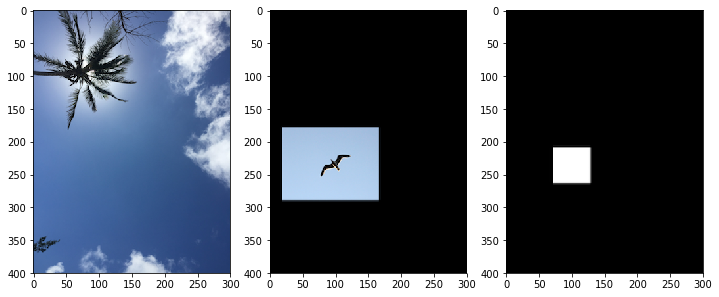

In [3]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(target_img)
axes[1].imshow(source_img)
axes[2].imshow(mask_img)

In [4]:
# Get indicies above, below, to the left and right
def get_surrounding(index):
    i, j = index
    return [(i + 1, j),
            (i - 1, j),
            (i, j + 1),
            (i, j - 1)]

In [5]:
def edge(index, mask):
    if  mask[index] == 0: 
        return False
    for pt in get_surrounding(index):
        if mask[index] == 0: 
            return True
    return False

In [6]:
# Apply the Laplacian operator at a given index
def lapl_at_index(source, index):
    i,j = index
    val = (4 * source[i,j])    \
           - (1 * source[i+1, j]) \
           - (1 * source[i-1, j]) \
           - (1 * source[i, j+1]) \
           - (1 * source[i, j-1])
    return val

In [7]:
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix

In [8]:
# Create the A sparse matrix
def poisson_sparse_matrix(points, size):
    A = lil_matrix((size, size))
    for index, point in enumerate((points)):
        # Should have 4's diagonal
        A[index, index] = 4
        # Get all surrounding points
        for x in get_surrounding(point):
            # If a surrounding point is in the mask, add -1 to index's
            # row at correct position
            if x not in points: 
                continue                
            A[index, points.index(x)] = -1
    return A

In [9]:
def fix_surrounding(b, index, i, target):
    for pt in get_surrounding(index):
        if mask[pt] == 0:
            b[i] += target[pt]

In [10]:
def get_b(indicies, source, target):
    b = np.zeros(len(indicies))
    for index, i in enumerate((indicies)):
        if mask[i] == 1:
            fix_surrounding(b, i, index, target)        
        b[index] += lapl_at_index(source, i)
    return b

In [11]:
def overlay(x, target, indicies):
    composite = np.copy(target).astype(int)
    for index, i in enumerate((indicies)):
          composite[i] = x[0][index]
    return composite

In [12]:
def process(source, target, mask):
    nonzero = np.nonzero(mask)
    indicies = tuple(zip(nonzero[0], nonzero[1]))
    
    A = poisson_sparse_matrix((indicies), len(indicies))
    b = get_b(indicies, source, target)

    x = linalg.cg(A, b)
    return overlay(x, target, indicies)

In [13]:
def normalize(mask_img):
    mask = np.atleast_3d(mask_img).astype(np.float) / 255.
    mask[mask != 1] = 0
    return mask[:,:,0]

In [14]:
channels = source_img.shape[-1]
mask = normalize(mask_img)    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


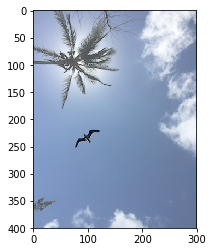

In [15]:
result_stack = []
for i in range(channels):
    result_stack.append(process(source_img[:,:,i], target_img[:,:,i], mask))

results = np.zeros(source_img.shape)
for index, i in enumerate(result_stack):
    results[:, :, index] = i
plt.imshow(scipy.misc.toimage(results))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


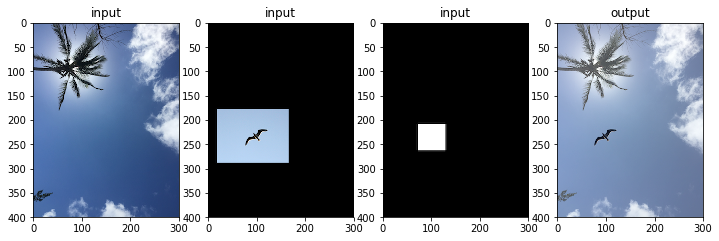

In [20]:
figure, axes = plt.subplots(1, 4, figsize=(12, 12))
axes[0].set_title("input")
axes[0].imshow(target_img)
axes[1].set_title("input")
axes[1].imshow(source_img)
axes[2].set_title("input")
axes[2].imshow(mask_img)
axes[3].set_title("output")
axes[3].imshow(scipy.misc.toimage(results))